In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 15: Hypothesis Testing

## Alameda County Jury Panels ##

Let's create a table of data from the ACLU, indicating the proportions of each ethnicity within the population of eligible jurors and on the jury panels.

In [2]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


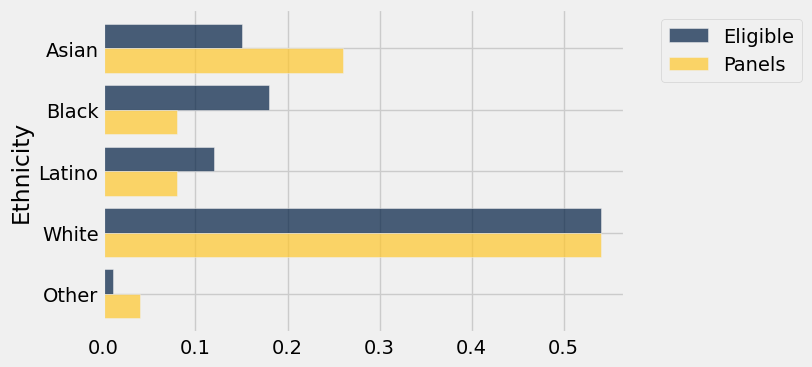

In [3]:
jury.barh('Ethnicity')

It looks like Asian panelists are overrepresented, while Black and Latino panelists are underrepresented. Are these differences statistically significant?

Let's simulate the model in which panelists are chosen by a simple random sample from the eligible population---i.e., everyone is equally likely to be selected. Remember the `sample_proportions` function?

In [4]:
sample_proportions?

We can use this function to simulate a random sample of 1,423 panelists from the eligible population, with probabilities equal to the proportions in the `Eligible` column. Instead of returning counts, the `sample_proportions` function calculates the fraction of the sample within each category:

In [5]:
jury.column('Eligible')
# Distribution representing 15% Asian, 18% Black, 12% Latino, etc.

array([ 0.15,  0.18,  0.12,  0.54,  0.01])

In [6]:
# Let's simulate a random draw of 1423 jurors from this distribution
simulated = sample_proportions(1423, jury.column('Eligible'))
simulated

array([ 0.13703443,  0.19184821,  0.11103303,  0.5509487 ,  0.00913563])

The actual observed distribution (usually) looks quite different from the simulation. Try running this several times to confirm!

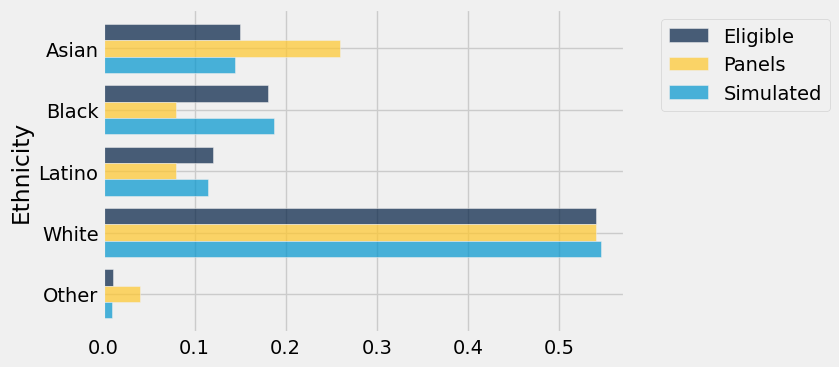

In [10]:
simulated = sample_proportions(1423, jury.column('Eligible'))
jury_with_simulated = jury.with_column('Simulated', simulated)
jury_with_simulated.barh('Ethnicity')

### Comparing Distributions: Total Variation Distance (TVD)

The *total variation distance* is a statistic for measuring the difference between two categorical distributions. The `jury` table contains two distributions: one in the `Panels` column, and one in the `Eligible` column. Let's calculate the TVD between these two distributions.

In [11]:
# Step 1: Calculate the differences in proportion / probability for each category
diffs = jury.column('Panels') - jury.column('Eligible')
jury_with_difference = jury.with_column('Step 1: Difference', diffs)
jury_with_difference

Ethnicity,Eligible,Panels,Step 1: Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


In [12]:
# Step 2: Calculate the absolute value of the differences
abs_diffs = jury_with_difference.apply(abs, 'Step 1: Difference')
jury_with_difference = jury_with_difference.with_column('Step 2: Abs. Differences', abs_diffs)
jury_with_difference

Ethnicity,Eligible,Panels,Step 1: Difference,Step 2: Abs. Differences
Asian,0.15,0.26,0.11,0.11
Black,0.18,0.08,-0.1,0.1
Latino,0.12,0.08,-0.04,0.04
White,0.54,0.54,0,0
Other,0.01,0.04,0.03,0.03


In [13]:
# Step 3: Calculate 0.5 times the sum of the absolute diferences
observed_tvd = 0.5 * sum(jury_with_difference.column('Step 2: Abs. Differences'))
print('The TVD between the Panel and Eligible distributions is:', observed_tvd)

The TVD between the Panel and Eligible distributions is: 0.14


**Question**: write a function called `tvd` that takes two arguments, `dist1` and `dist2`, which are **arrays** of numbers (summing to 1) indicating proportions in two different distributions. The function should return the total variation distance between the two distributions. For example, if `dist1 = make_array(0.15, 0.18, 0.12, 0.54, 0.01)` and `dist2 = make_array(0.26, 0.08, 0.08, 0.54, 0.04)`, then it should be true that `tvd(dist1, dist2) == 0.14`.

In [14]:
def tvd(dist1, dist2):
    """
    Calculate the total variation distance between two distributions,
    dist1 and dist2, which are represented as arrays.
    """
    
    # Step 1: calculate the differences in proportions / probabilities for each category
    diff = dist1 - dist2
    
    # Step 2: calculate the absolute values of these differences
    abs_diff = abs(diff)
    
    # Step 3: sum up and divide by 2
    value = sum(abs_diff) / 2
    
    return value

In [15]:
# Test the function
dist1 = jury.column('Eligible')
dist2 = jury.column('Panels')
tvd(dist1, dist2) == 0.14  # This should be True!

True

In [16]:
# The TVD of two identical distributions should be zero
tvd(jury.column('Eligible'), jury.column('Eligible'))

0.0

**Challenge question:** what is the largest possible value of the TVD between any two distributions?

In [ ]:
# Max value is 1
# any two distributions dist1, dist2, we know that 0 <= tvd(dist1, dist2) <= 1

After using the `sample_proportions` function to simulate the jury composition under the "all eligible members have an equal selection probability" model, we can calculate the value of the TVD statistic between this simulated distribution and the distribution of the eligible population:

In [19]:
# The TVD of a model simluation from its expected values
model = jury.column('Eligible')
tvd(sample_proportions(1423, model), jury.column('Eligible'))

0.02823612087139846

### Use TVD to Decide if the Jury Selection is Biased

In [20]:
def simulated_tvd():
    """
    Simulate the TVD between the eligible population and panel distributions, 
    according to the model where panels are simple random samples of the
    eligible population.
    """
    sampled_panel_proportions = sample_proportions(1423, jury.column('Eligible'))
    return tvd(sampled_panel_proportions, jury.column('Eligible'))

In [21]:
# Sample the distribution of TVDs under the "unbiased random selection" model
tvds = make_array()
num_simulations = 10000
for i in np.arange(num_simulations):
    new_tvd = simulated_tvd()
    tvds = np.append(tvds, new_tvd)

In [23]:
len(tvds)

10000

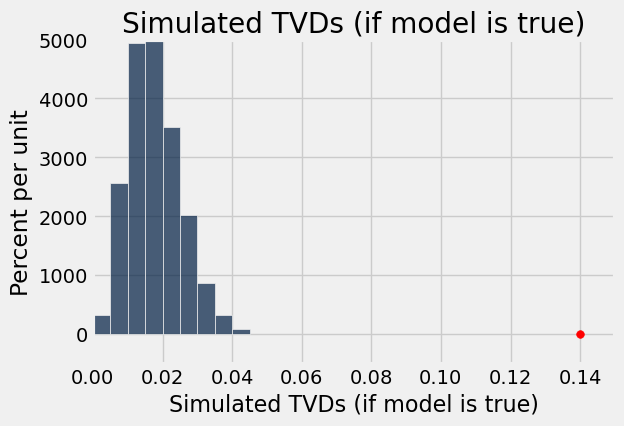

In [24]:
# Use a histogram to visualize the empirical distribution of the TVD under the model
title = 'Simulated TVDs (if model is true)'
bins = np.arange(0, .05, .005)
Table().with_column(title, tvds).hist(bins = bins)

# Place a red dot where the actual observed TVD lies compared to this distribution
# You can ignore this code if you'd like.
# But if you're interested in what we're doing here, you can check out the matplotlib documentation:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlim.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
plots.xlim(0, 0.15)
plots.ylim(-5, 50)
plots.scatter(observed_tvd, 0, color='red', s=30)
plots.title(title);

**Question:** is the model of unbiased random sampling consistent with the observed data? What does that mean?

In [ ]:
# Observed statistic (0.14) is far from the simulated values
# So we conclude that the model is inconsistent with the data

## Hypothesis Testing: Basic Example

Suppose I found a coin on the sidewalk and want to see if it's biased (i.e., not a 50-50 chance of landing heads-tails). I flipped the coin 100 times, and recorded the results in the following table:

In [25]:
flips = Table.read_table('./data/coin-flips.csv')
flips.show(4)

Flip,Outcome
0,tails
1,heads
2,tails
3,tails


**Question 1:** what would be a good **null hypothesis** here? I.e., what model could we simulate to help us decide if the coin is biased?

In [ ]:
# What model can I simulate to assess whether or not the coin is fair?
# Null hypothesis: coin lands on heads with probability 50%, lands on tails with probability 50%

**Question 2:** given this null hypothesis, what is the natural **alternative hypothesis**? I.e., what should we accept as true if we manage to disprove the null hypothesis?

In [ ]:
# What do we learn if the null hypothesis is wrong?
# Alternative hypothesis: the coin is not 50-50 heads tails

**Question 3:** what should I use as a **test statistic**? And what is the observed value of this test statistic from the `flips` table?

In [ ]:
# What test statistic have we already talked about to decide if a coin is fair or not?
# If the coin is fair and we flip it 100 times, how many times we we expect it to land on heads?
# 50!
# If we get many more or many less than 50 heads out of 100 flips, that suggests a biased coin.
# How can we quantify this?
# Use abs(number_of_heads - 50)
# If abs(number_of_heads - 50) is a large number, what does that suggest? 
# Many more or many less than 50 heads, suggesting a biased coin.

**Question 4:** write code to simulate the value of the test statistic under the null hypothesis 10,000 times. Plot a histogram of this empirical distribution of the statistic.

In [26]:
simulated_flips = np.random.choice(make_array('heads', 'tails'), 100)

In [30]:
np.count_nonzero(simulated_flips == 'heads')

52

In [31]:
test_statistics = make_array()
for i in np.arange(10000):
    
    # Sample the outcome of 100 fair coin flips
    simulated_flips = np.random.choice(make_array('heads', 'tails'), 100)
    
    # Calculate the value of the test statistic from this simulated outcome
    number_of_heads = sum(simulated_flips == 'heads')
    test_stat = abs(number_of_heads - 50)
    
    # Add test stat to the test_statistics array
    test_statistics = np.append(test_statistics, test_stat)

**Question 5:** Based on this histogram and the oserved value of the test statistic from Question 3, can we reject the null hypothesis or not?

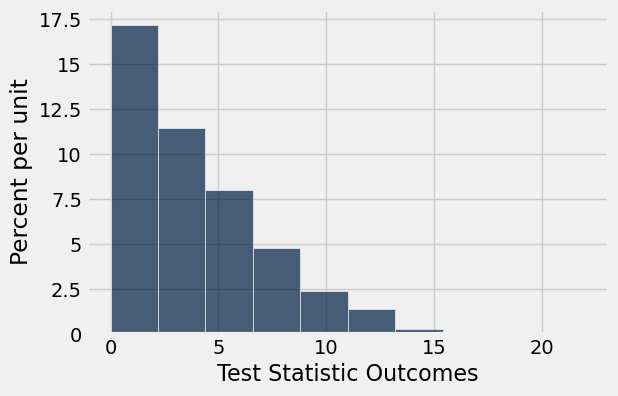

In [34]:
Table().with_column('Test Statistic Outcomes', test_statistics).hist()

In [38]:
obs_statistic = abs(52 - 50)
obs_statistic

2

**Question 6:** If we fail to reject the null hypothesis, does this imply that the null hypothesis is probably true? I.e., have we proven that the coin has an equal chance of landing on heads or tails?

In [ ]:
# No! In fact, in the data in the flips table was generated from a coin with a 55% chance of landing on heads.
# Just because we don't have enough evidence to disprove the null hypothesis doesn't imply that the null hypothesis is correct.

## Hypothesis Testing: Commute Times

Let's define a "short commute" as a commute that is strictly less than 15 minutes. According to [Statista](https://www.statista.com/chart/24684/average-duration-of-a-one-way-commute/), 24% of Americans have a short commute. Since many of you live on campus or in IV, we might expect the fraction of students in CMPSC 5a who have a short commute is higher. Does the evidence support this claim?

**Question:** if everone in the class had filled out the class data survey, would we need to do a hypothesis test?

In [ ]:
# ...

**Null hypothesis:** 24% of students in CMPSC 5a have a short commute.

**Alternative Hypothesis:** the fraction of CMPSC 5a students who have a short commute is *not* 24%.

To perform a hypothesis test, let's load and clean the `Commute Time` column from the class data survey.

In [ ]:
class_data = Table.read_table('./data/cmpsc5a-classdata-w23.csv')
commute_data = class_data.where('Commute Time', are.above_or_equal_to(0)).select('Commute Time')
commute_data.show(5)

**Question:** what test statistic should we use? Calculate the observed value of the test statistic from the `commute_data` table.

In [ ]:
# ...

To approximate the distribution of the test statistic, we will need to simulate the results of the class survey (at least the `Commute Time` column) under the null hypothesis. In other words, we will simulate what fraction of the 78 respondents have a short commute, if 24% of the class has a short commute.

In [ ]:
def simulate_responses():
    """
    Simulate the fraction of survey respondents with a short commute,
    under the null hypothesis that 28% of the class has a short commute.
    """
    outcome_probabilities = make_array(0.24, 0.76)
    n_responses = 78
    simulated_fractions = sample_proportions(n_responses, outcome_probabilities)
    return simulated_fractions.item(0)

We will approximate the distribution of the test statistic under the null hypothesis by simulating the responses 10,000 times. We will then plot a histogram of the results, and compare it to the observed value of the test statistic.

In [ ]:
simulated_stats = make_array()
for i in range(10000):
    simulated_stats = np.append(simulated_stats, simulate_responses())
    
# Generate a histogram for the distribution of the test statistic
my_bins = np.arange(0, 0.6, 0.025)
Table().with_column('Simulated Fraction with Short Commute', simulated_stats).hist(0, bins=my_bins)

# Plot the observed value of the test statistic
plots.ylim([-0.5, 9])
plots.scatter(observed_frac, 0, color='red', s=30);

**Question:** can we reject the null hypothesis? And does the location of the test statistic tell us whether the true fraction of the class with a short commute is greater than or less than 24%?

In [ ]:
# ...

## Hypothesis Testing: Random Numbers

In the class data survey, we asked you to select a "very random 4-digit number." Let's see how random your random numbers actually were.

**Null Hypothesis:** survey respondents selected truly random 4-digit numbers (with each possibility equally likely).

**Alternative Hypothesis:** your numbers were not truly random (at least not uniformly distributed).

Let's load the `Random` column to see which numbers were submitted:

In [ ]:
random_nums_data = class_data.where('Random', are.above_or_equal_to(1000)).select('Random')
random_nums_data.show(5)
print('Number of responses (after cleaning):', random_nums_data.num_rows)

In [ ]:
# Visualize the responses in a histogram
four_digit_bins = np.arange(1000, 10000, 500)
random_nums_data.relabeled('Random', 'Response').hist(bins=four_digit_bins)
plots.title('Distribution of "Random" Numbers from the Survey');

In order to simulate survey responses under the null hypothesis, we can use the `np.random.choice` function:

In [ ]:
possibilities = np.arange(1000, 10000) # List all the possible 4-digit numbers
sample_size = 81 # How many 4-digit numbers should we draw to simulate the survey outcome?
simulated_random_responses = np.random.choice(possibilities, sample_size)

In [ ]:
# Use a histogram to visualize the simulated random responses
Table().with_column('Response', simulated_random_responses).hist(bins=four_digit_bins) 
plots.title('Simulated Distribution of 81 Truly Random Numbers');

**Question:** what test statistic can we use to compare the distribution of survey responses to the distribution in which each 4-digit number is equally likely?

In [ ]:
# ...

In [ ]:
def compute_4_digit_distribution(numbers):
    """
    Takes an array of 4-digit numbers.
    For each possible 4-digit number 1000, 1001, ..., 9999, calculate the fraction of the time
    this integer shows up in the numbers array.
    Returns an array with 9,000 entries that sum to 1.
    """
    
    # Make sure that numbers are integers
    numbers_as_ints = numbers.astype(int)
    
    # The np.bincount function counts how many times the values 0, 1, 2, ... show up in an array
    # The function returns an array of these counts
    counts = np.bincount(numbers_as_ints - 1000, minlength=9000)
    
    # Divide by len(counts) to convert counts into proportions
    return counts / len(counts)

In [ ]:
compute_4_digit_distribution(random_nums_data.column('Random'))

In order to calculate this statistic, we will need to construct the distribution of numbers under the null hypothesis. Since there are 9,000 four-digit numbers, if each is equally likely, it will occur with probability 1/9000. Therefore, we can represent the distribution of numbers under the null hypothesis with the following array:

In [ ]:
uniform_distribution_probabilities = np.ones(9000) / 9000
uniform_distribution_probabilities

Then we can use our `tvd` function from earlier to calculate total variation distances.

In [ ]:
simulated_tvds = make_array()
for i in range(2000):
    
    simulated_random_responses = np.random.choice(possibilities, sample_size)
    simulated_response_distribution = compute_4_digit_distribution(simulated_random_responses)
    simulated_tvds = np.append(simulated_tvds, tvd(uniform_distribution_probabilities, simulated_response_distribution))

Finally, we plot a histogram of the results, and compare this empirical distribution of the test statistic to the value of the statistic from the class distribution:

In [ ]:
# Create a histogram of simulated TVDs
tvd_bins_small = np.arange(0.4950, 0.4960, 0.0002)
Table().with_column('Simulated TVDs', simulated_tvds).hist(bins=tvd_bins_small)

# Plot the observed value of the test statistic 
observed_tvd = tvd(
    compute_4_digit_distribution(random_nums_data.column('Random')),
    uniform_distribution_probabilities)
plots.ylim([-500, 3400])
plots.scatter(observed_tvd, 0, color='red', s=30);

In [ ]:
# Calculate what fraction of the simulated TVDs are below that of the class TVD
print('Fraction of simulated TVDs that are less than the class TVD:', 
      np.average(simulated_tvds < observed_tvd))

**Question:** what can we conclude from this test?

In [ ]:
# ...